In [2]:
import Pkg; Pkg.add("ForwardDiff")

    Updating registry at `C:\Users\AllanStruthers\.julia\registries\General`
┌ Info: The General registry is installed via git. Consider reinstalling it via
│ the newer faster direct from tarball format by running:
│   pkg> registry rm General; registry add General
└ 
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
   Installed ForwardDiff ─ v1.2.1
    Updating `C:\Users\AllanStruthers\.julia\environments\v1.11\Project.toml`
  [f6369f11] + ForwardDiff v1.2.1
    Updating `C:\Users\AllanStruthers\.julia\environments\v1.11\Manifest.toml`
  [f6369f11] ↑ ForwardDiff v1.1.0 ⇒ v1.2.1
Precompiling project...
   3370.9 ms  ✓ ForwardDiff
    943.9 ms  ✓ ForwardDiff → ForwardDiffStaticArraysExt
  2 dependencies successfully precompiled in 16 seconds. 454 already precompiled.
  2 dependencies precompiled but different versions are currently loaded. Restart julia to access the new versions. Otherwise, loading dependents of these packages may 

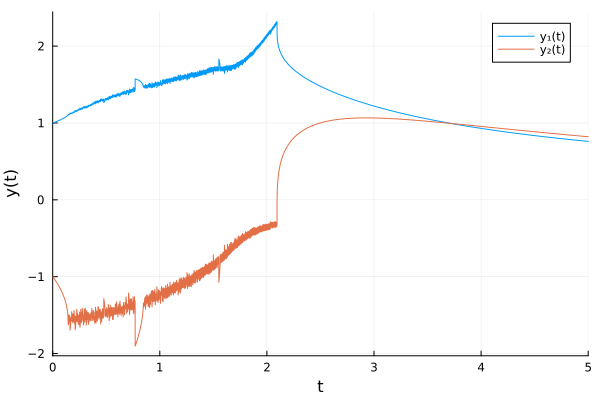

In [3]:
using DifferentialEquations
using ForwardDiff

# Example vector-valued function h(y,t): R^n × R → R^n
function h(y, t)
    # simple nonlinear system with explicit time dependence
    return [
        y[1]^2 + t*y[2],
        sin(y[2]) + t*y[1]
    ]
end

# A(y,t) = Jacobian wrt y (matrix)
function A(y, t)
    return ForwardDiff.jacobian(yy -> h(yy, t), y)
end

# f(y,t) = ∂h/∂t (vector)
function f(y, t)
    n = length(h(y,t))
    ft = similar(y)
    for i in 1:n
        ft[i] = ForwardDiff.derivative(tt -> h(y, tt)[i], t)
    end
    return ft
end

# Define the ODE system: y'(t) = -A(y,t)^{-1} f(y,t)
function ode!(dy, y, p, t)
    Ay = A(y, t)
    ft = f(y, t)
    dy[:] = -Ay \ ft
end

# Initial condition and timespan
y0 = [1.0, -1.0]
tspan = (0.0, 5.0)

# Solve ODE
prob = ODEProblem(ode!, y0, tspan)
sol = solve(prob, Tsit5())

using Plots
plot(sol, xlabel="t", ylabel="y(t)", label=["y₁(t)" "y₂(t)"])


Below is a mass-matrix variant that should be better near any singularities in A. 

In [5]:
using Pkg
Pkg.add("Sundials")

   Resolving package versions...
    Updating `C:\Users\AllanStruthers\.julia\environments\v1.11\Project.toml`
⌅ [c3572dad] + Sundials v4.28.0
  No Changes to `C:\Users\AllanStruthers\.julia\environments\v1.11\Manifest.toml`


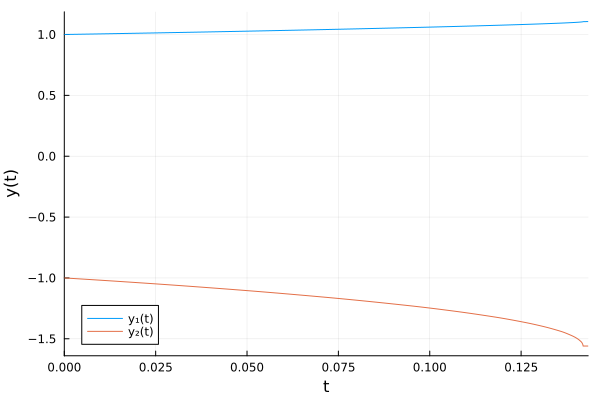

In [6]:
using DifferentialEquations, Sundials
using ForwardDiff

# Example vector-valued function h(y,t): R^n × R → R^n
function h(y, t)
    return [
        y[1]^2 + t*y[2],
        sin(y[2]) + t*y[1]
    ]
end

# A(y,t) = Jacobian wrt y (matrix)
function A(y, t)
    return ForwardDiff.jacobian(yy -> h(yy, t), y)
end

# f(y,t) = ∂h/∂t (vector)
function f(y, t)
    n = length(h(y,t))
    ft = similar(y)
    for i in 1:n
        ft[i] = ForwardDiff.derivative(tt -> h(y, tt)[i], t)
    end
    return ft
end

# Residual form: A(y,t)*dy + f(y,t) = 0
function dae_residual!(res, dy, y, p, t)
    res[:] = A(y, t) * dy + f(y, t)
end

# Initial condition
y0 = [1.0, -1.0]

# Need a consistent initial derivative dy0 satisfying A(y0,t0)*dy0 + f(y0,t0) = 0
t0 = 0.0
dy0 = -A(y0,t0) \ f(y0,t0)

# Problem setup
tspan = (0.0, 5.0)
prob = DAEProblem(dae_residual!, dy0, y0, tspan)

# Solve
sol = solve(prob, IDA())   # IDA = Sundials DAE solver

using Plots
plot(sol, xlabel="t", ylabel="y(t)", label=["y₁(t)" "y₂(t)"])
